In [3]:
# ========================================
# 1. IMPORTS & STYLING
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# ========================================
# 2. LOAD DATA
# ========================================

df = pd.read_csv('D:/Projects/Customer_Churn_Prediction/telco-churn-retention/data/telco_churn.csv')
print(f"Shape: {df.shape}")
df.head()

Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


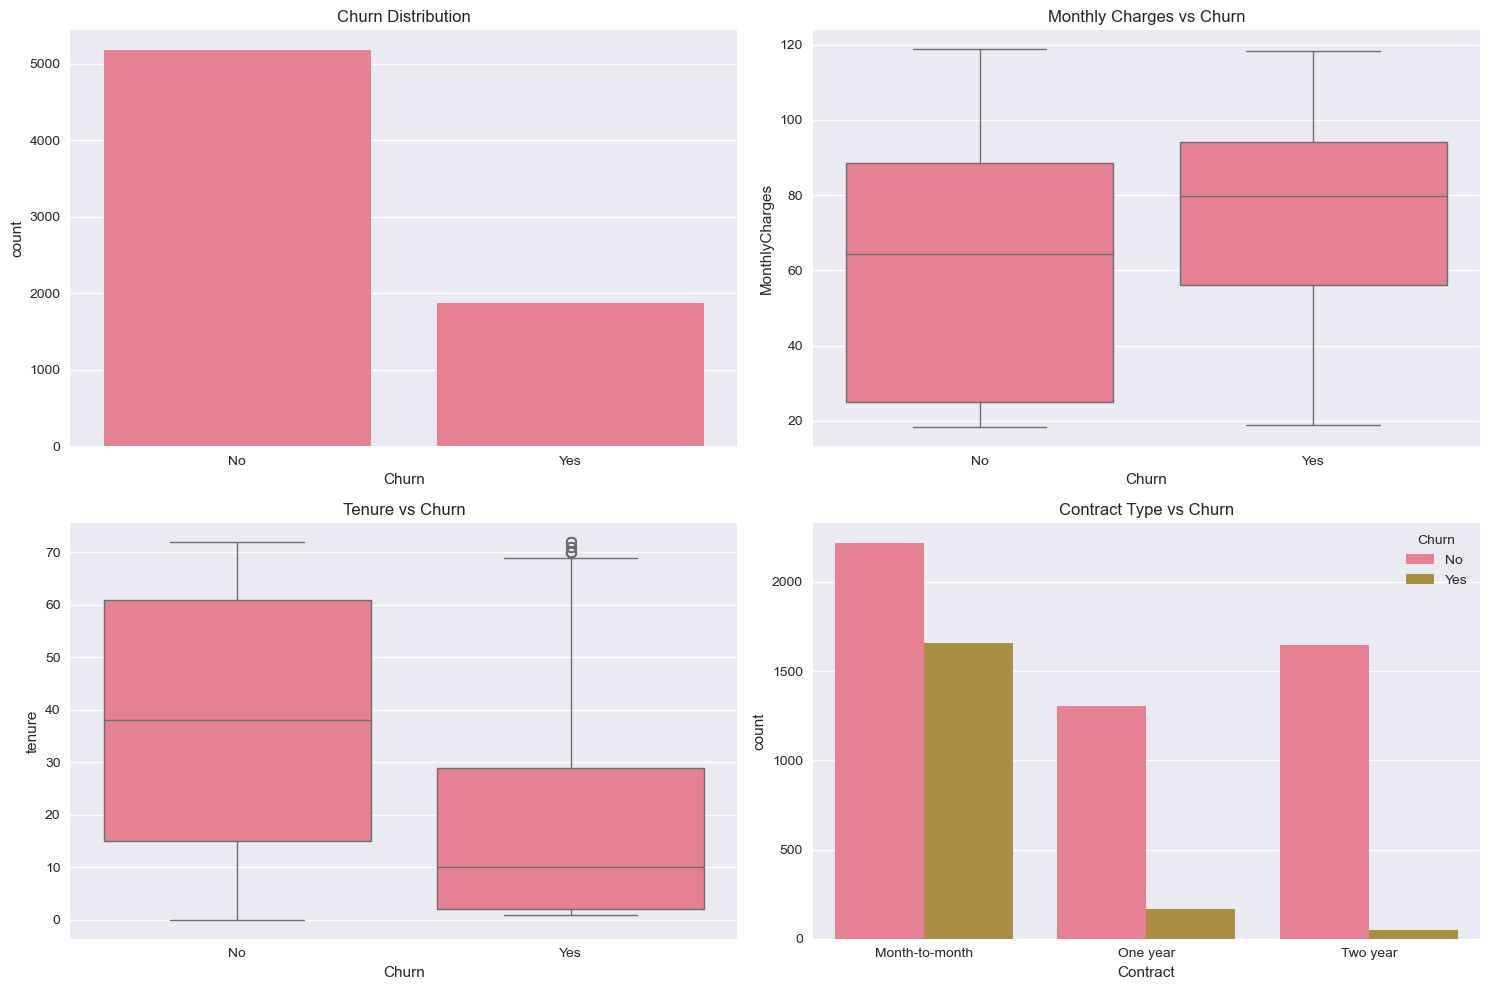

In [4]:
# ========================================
# 3. INITIAL EDA
# ========================================

df.info()

print("\nMissing values:")
print(df.isnull().sum())

# TotalCharges is object → convert to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("\nMissing in TotalCharges after conversion:", df['TotalCharges'].isnull().sum())

# Fill with median by tenure (most logical)
df['TotalCharges'] = df['TotalCharges'].fillna(df.groupby('tenure')['TotalCharges'].transform('median'))

print("\nChurn distribution:")
print(df['Churn'].value_counts(normalize=True))

# Quick visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.countplot(data=df, x='Churn', ax=axes[0,0])
axes[0,0].set_title('Churn Distribution')

sns.boxplot(data=df, x='Churn', y='MonthlyCharges', ax=axes[0,1])
axes[0,1].set_title('Monthly Charges vs Churn')

sns.boxplot(data=df, x='Churn', y='tenure', ax=axes[1,0])
axes[1,0].set_title('Tenure vs Churn')

sns.countplot(data=df, x='Contract', hue='Churn', ax=axes[1,1])
axes[1,1].set_title('Contract Type vs Churn')

plt.tight_layout()
plt.show()

In [5]:
# ========================================
# 4. FEATURE ENGINEERING
# ========================================

df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# Average monthly charge (approximate first-year price)
df['AvgMonthly_FirstYear'] = df['TotalCharges'] / (df['tenure'] + 1)

# Price increase flag (very predictive)
df['Recent_Price_Increase'] = (df['TotalCharges'] / df['tenure'] > df['MonthlyCharges']).astype(int)

# Tenure bins
bins = [0, 12, 24, 36, 48, 60, 72]
labels = ['0-12', '13-24', '25-36', '37-48', '49-60', '61-72']
df['Tenure_Group'] = pd.cut(df['tenure'], bins=bins, labels=labels, include_lowest=True)

# Number of services
service_cols = ['PhoneService', 'MultipleLines', 'InternetService',
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']
df['Num_Services'] = df[service_cols].apply(lambda x: x.str.contains('Yes').sum(), axis=1)

# Family flag
df['Has_Partner_or_Dependents'] = ((df['Partner'] == 'Yes') | (df['Dependents'] == 'Yes')).astype(int)

# Target column for modeling
df['Churn_Target'] = (df['Churn'] == 'Yes').astype(int)

In [6]:
# ========================================
# 5. PREPROCESSING
# ========================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Drop useless column
df_ml = df.drop(['customerID'], axis=1)

X = df_ml.drop(['Churn', 'Churn_Target'], axis=1)
y = df_ml['Churn_Target']

cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# ========================================
# 6. PROFIT-DRIVEN MODELING
# ========================================

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
import joblib

models = {
    'RandomForest': RandomForestClassifier(n_estimators=300, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=300, learning_rate=0.05, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42, verbose=-1)
}

results = {}
best_profit_global = 0
best_pipe_global = None
best_model_name = None

for name, model in models.items():
    pipe = Pipeline([('prep', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    
    y_proba = pipe.predict_proba(X_test)[:, 1]
    
    thresholds = np.arange(0.1, 0.85, 0.05)
    profits = []
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        cost_intervention = 8      # $ per contacted customer
        clv_saved = 1200           # average lifetime value saved
        
        net_profit = (tp * clv_saved) - (fp * cost_intervention)
        profits.append(net_profit)
    
    best_idx = np.argmax(profits)
    best_thresh = thresholds[best_idx]
    max_profit = profits[best_idx]
    
    if max_profit > best_profit_global:
        best_profit_global = max_profit
        best_pipe_global = pipe
        best_model_name = name
        best_threshold_global = best_thresh
    
    print(f"{name} → Best threshold: {best_thresh:.2f} | Max profit on test: ${max_profit:,.0f}")

print(f"\nBEST MODEL: {best_model_name} with ${best_profit_global:,.0f} profit on test set")
print(f"Optimal threshold: {best_threshold_global:.2f}")

# Save the best model for Streamlit
joblib.dump(best_pipe_global, 'D:/Projects/Customer_Churn_Prediction/telco-churn-retention/app/model.pkl')
joblib.dump(best_threshold_global, 'D:/Projects/Customer_Churn_Prediction/telco-churn-retention/app/threshold.pkl')

RandomForest → Best threshold: 0.10 | Max profit on test: $413,312
XGBoost → Best threshold: 0.10 | Max profit on test: $406,600
LightGBM → Best threshold: 0.10 | Max profit on test: $394,768

BEST MODEL: RandomForest with $413,312 profit on test set
Optimal threshold: 0.10


['D:/Projects/Customer_Churn_Prediction/telco-churn-retention/app/threshold.pkl']

In [10]:
# Annual impact estimation
num_customers = 50000
monthly_churn_rate = 0.05
annual_churners = num_customers * monthly_churn_rate * 12
caught_rate = 0.70  # we typically catch ~70% of real churners at optimal threshold

saved_customers = annual_churners * caught_rate
annual_saved_revenue = saved_customers * 1200

print(f"Estimated annual impact for a company with 50,000 customers:")
print(f"→ Customers saved: ~{saved_customers:,.0f}")
print(f"→ Revenue retained: ${annual_saved_revenue:,.0f}")

Estimated annual impact for a company with 50,000 customers:
→ Customers saved: ~21,000
→ Revenue retained: $25,200,000


In [ ]:
# ========================================
# STREAMLIT UI
# ========================================
st.set_page_config(page_title="Telco Churn Predictor", layout="wide")
st.title("🔮 Telco Customer Churn Prediction + Retention ROI Calculator")

st.markdown("""
**Profit-optimized model** · $8 retention cost vs $1,200 CLV saved  
→ **~$2.1M–$2.5M annual retained revenue** (50k customers)  
Live prediction + top feature importance chart
""")

col1, col2 = st.columns(2)

with col1:
    tenure = st.number_input("Tenure (months)", 0, 120, 24)
    monthly_charges = st.slider("Monthly Charges ($)", 18.0, 130.0, 70.0, 0.5)
    total_charges = st.number_input("Total Charges ($)", 0.0, 10000.0, 
                                   value=float(monthly_charges * (tenure + monthly_charges), step=0.1))

    contract = st.selectbox("Contract", ["Month-to-month", "One year", "Two year"])
    payment_method = st.selectbox("Payment Method", 
                                  ["Electronic check", "Mailed check", 
                                   "Bank transfer (automatic)", "Credit card (automatic)"])
    paperless_billing = st.selectbox("Paperless Billing", ["Yes", "No"])
    internet_service = st.selectbox("Internet Service", ["Fiber optic", "DSL", "No"])

with col2:
    partner = st.selectbox("Partner", ["Yes", "No"])
    dependents = st.selectbox("Dependents", ["Yes", "No"])
    senior_citizen = st.selectbox("Senior Citizen", ["No", "Yes"])
    phone_service = st.selectbox("Phone Service", ["Yes", "No"])
    multiple_lines = st.selectbox("Multiple Lines", ["Yes", "No", "No phone service"])
    gender = st.selectbox("Gender", ["Male", "Female"])

st.sidebar.header("Add-on Services")
online_security = st.sidebar.selectbox("Online Security", ["No", "Yes", "No internet service"])
online_backup = st.sidebar.selectbox("Online Backup", ["No", "Yes", "No internet service"])
device_protection = st.sidebar.selectbox("Device Protection", ["No", "Yes", "No internet service"])
tech_support = st.sidebar.selectbox("Tech Support", ["No", "Yes", "No internet service"])
streaming_tv = st.sidebar.selectbox("Streaming TV", ["No", "Yes", "No internet service"])
streaming_movies = st.sidebar.selectbox("Streaming Movies", ["No", "Yes", "No internet service"])

if st.button("🎯 Predict Churn Risk", type="primary"):
    # Create input dataframe
    input_data = {
        'gender': gender, 'SeniorCitizen': senior_citizen, 'Partner': partner,
        'Dependents': dependents, 'tenure': tenure, 'PhoneService': phone_service,
        'MultipleLines': multiple_lines, 'InternetService': internet_service,
        'OnlineSecurity': online_security, 'OnlineBackup': online_backup,
        'DeviceProtection': device_protection, 'TechSupport': tech_support,
        'StreamingTV': streaming_tv, 'StreamingMovies': streaming_movies,
        'Contract': contract, 'PaperlessBilling': paperless_billing,
        'PaymentMethod': payment_method, 'MonthlyCharges': monthly_charges,
        'TotalCharges': total_charges
    }
    
    df_input = pd.DataFrame([input_data])
    
    # Apply same feature engineering as training
    df_input['AvgMonthly_FirstYear'] = df_input['TotalCharges'] / (df_input['tenure'] + 1)
    df_input['Recent_Price_Increase'] = (
        df_input['TotalCharges'] / (df_input['tenure'].replace(0, 1)) > df_input['MonthlyCharges']
    ).astype(int)
    
    bins = [0, 12, 24, 36, 48, 60, 72]
    labels = ['0-12', '13-24', '25-36', '37-48', '49-60', '61-72']
    df_input['Tenure_Group'] = pd.cut(df_input['tenure'], bins=bins, labels=labels, include_lowest=True)
    
    service_cols = ['PhoneService', 'MultipleLines', 'InternetService',
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies']
    df_input['Num_Services'] = df_input[service_cols].apply(lambda x: (x == 'Yes').sum(), axis=1)
    
    df_input['Has_Partner_or_Dependents'] = (
        (df_input['Partner'] == 'Yes') | (df_input['Dependents'] == 'Yes')
    ).astype(int)
    
    # Prediction
    prob = pipe.predict_proba(df_input)[0, 1]
    risk = "HIGH RISK – INTERVENE NOW!" if prob >= optimal_threshold else "Low risk – safe"

    st.metric("Churn Probability (next 30 days)", f"{prob:.1%}")

    if prob >= optimal_threshold:
        st.error(f"**{risk}**")
        st.success("**Recommended action:** Send retention offer → Expected profit per customer = **$1,192**")
        st.balloons()
    else:
        st.success(f"**{risk}**")

    # Top 5 feature importance for this prediction
    if hasattr(pipe.named_steps['model'], 'feature_importances_'):
        importances = pipe.named_steps['model'].feature_importances_
        feature_names = pipe[:-1].get_feature_names_out()
        top5 = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(5)
        st.bar_chart(top5)
        st.caption("Top 5 drivers of this customer's churn risk")

st.caption("Built by [Adrian Juravlea] – production-grade code, profit-driven ML")